In [28]:
#importing required libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import random
import numpy as np
from model import Net # importing the best model created 

In [29]:
# setting up constants
EPOCHS = 20
BATCH_SIZE = 64

In [30]:
# using gpu if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [31]:
# setting the transforms and normalizing the images
train_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomRotation((-7.0, 7.0)),
                        transforms.RandomAffine(0, (0.05, 0.05))
])
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
])

In [32]:
# creating train and test dataset
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [33]:
SEED = 22

cuda = torch.cuda.is_available()
print(cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


True


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0004)
 - std: tensor(0.1133)
 - var: tensor(0.0128)
torch.Size([128, 1, 28, 28])
torch.Size([128])


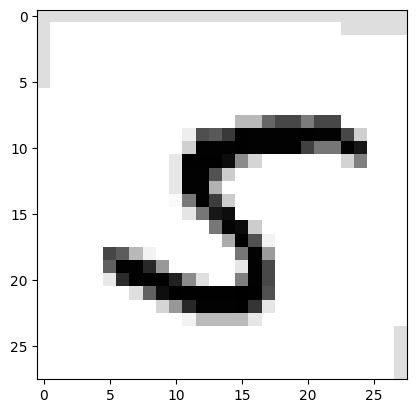

In [34]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

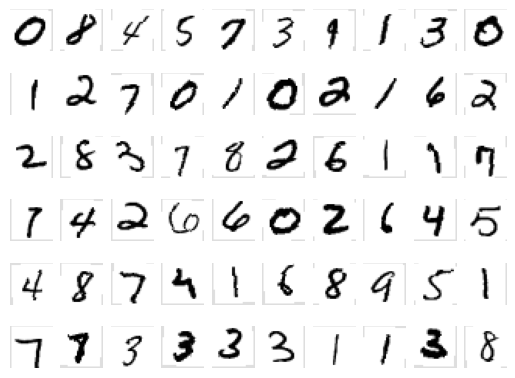

In [35]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### train and test functions

In [36]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, l1_loss = False, lambda_l1= 0.01):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    # if L1 regularization
    if l1_loss == True:
        l1 = 0
        for p in model.parameters():
            l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1 * l1
    
    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

misclassified = []

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified.clear()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            if epoch == EPOCHS-1:
                idxs_mask = ((pred == target.view_as(pred)) == False).view(-1)
                if idxs_mask.sum() == 1:
                    misclassified.append([data[idxs_mask].squeeze().unsqueeze(0).cpu().numpy(), target[idxs_mask].cpu().numpy(), pred[idxs_mask].squeeze().unsqueeze(0).cpu().numpy()])
                elif idxs_mask.sum() > 1:
                    misclassified.append([data[idxs_mask].squeeze().cpu().numpy(), target[idxs_mask].cpu().numpy(), pred[idxs_mask].squeeze().cpu().numpy()])
                    
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

#### Plotting misclassified images

In [37]:
def plot_misclassified(misclassified):
    temp_image = misclassified[0][0]
    temp_label = misclassified[0][1]
    temp_pred = misclassified[0][2]
    for i in range(1, len(misclassified)):
        temp_image = np.concatenate((temp_image, misclassified[i][0]), axis=0)
        temp_label = np.concatenate((temp_label, misclassified[i][1]), axis=0)
        temp_pred = np.concatenate((temp_pred, misclassified[i][2]), axis=0)
    miss = [temp_image, temp_label, temp_pred]

    index = [random.randint(0, len(misclassified)) for _ in range(10)]
    for i in range(1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(miss[0][index[i-1]], cmap='gray_r')
        plt.xlabel(f"Actual: {miss[1][index[i-1]]} \nPredicted:{miss[2][index[i-1]]}")
        plt.tick_params('both', bottom=False, top=False, left=False, right=False, 
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    

In [48]:
losses = []
accuracies = []

## Layer Normalization

In [49]:
model_ = Net(norm='ln').to(device)
summary(model_, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
         GroupNorm-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
         GroupNorm-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             576
        GroupNorm-12            [-1, 8, 10, 10]              16
             ReLU-13            [-1, 8, 10, 10]               0
          Dropout-14            [-1, 8,

In [50]:
model =  Net(norm='ln').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader, epoch)

EPOCH: 0


Loss=0.15373258292675018 Batch_id=468 Accuracy=75.65: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s] 



Test set: Average loss: 0.1767, Accuracy: 9457/10000 (94.57%)

EPOCH: 1


Loss=0.14276337623596191 Batch_id=468 Accuracy=95.78: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s] 



Test set: Average loss: 0.0731, Accuracy: 9774/10000 (97.74%)

EPOCH: 2


Loss=0.00900389812886715 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s] 



Test set: Average loss: 0.0631, Accuracy: 9781/10000 (97.81%)

EPOCH: 3


Loss=0.11680673807859421 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s] 



Test set: Average loss: 0.0413, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.0720306932926178 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]   



Test set: Average loss: 0.0304, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.16896717250347137 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s] 



Test set: Average loss: 0.0275, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.010166979394853115 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s] 



Test set: Average loss: 0.0281, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.02652774751186371 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s] 



Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.048948392271995544 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s] 



Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.011537160724401474 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s] 



Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.043514009565114975 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s] 



Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.18910832703113556 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s] 



Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.008372580632567406 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 29.46it/s] 



Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.035779062658548355 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s] 



Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.05188934504985809 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]  



Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)

EPOCH: 15


Loss=0.016585132107138634 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]



Test set: Average loss: 0.0266, Accuracy: 9916/10000 (99.16%)

EPOCH: 16


Loss=0.045089345425367355 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s] 



Test set: Average loss: 0.0266, Accuracy: 9916/10000 (99.16%)

EPOCH: 17


Loss=0.011567591689527035 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s] 



Test set: Average loss: 0.0266, Accuracy: 9916/10000 (99.16%)

EPOCH: 18


Loss=0.024163125082850456 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s] 



Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)

EPOCH: 19


Loss=0.017954444512724876 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s] 



Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)



In [51]:
losses.append(test_losses)
accuracies.append(test_acc)

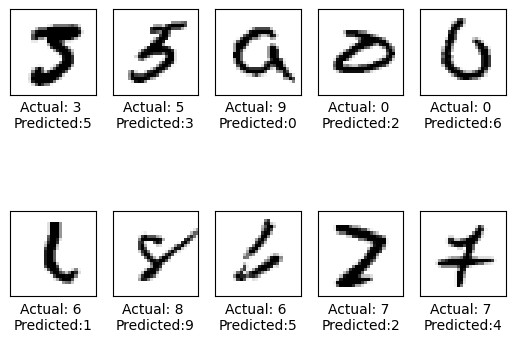

In [53]:
plot_misclassified(misclassified)

## Group Normalization

In [56]:
model_ = Net(norm='gn').to(device)
summary(model_, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
         GroupNorm-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
         GroupNorm-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             576
        GroupNorm-12            [-1, 8, 10, 10]              16
             ReLU-13            [-1, 8, 10, 10]               0
          Dropout-14            [-1, 8,

In [57]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [59]:
model =  Net(norm='gn').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader, epoch)

EPOCH: 0


Loss=0.34116312861442566 Batch_id=468 Accuracy=71.11: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]



Test set: Average loss: 0.2617, Accuracy: 9163/10000 (91.63%)

EPOCH: 1


Loss=0.196938157081604 Batch_id=468 Accuracy=92.62: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]  



Test set: Average loss: 0.1107, Accuracy: 9638/10000 (96.38%)

EPOCH: 2


Loss=0.12033248692750931 Batch_id=468 Accuracy=95.34: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s] 



Test set: Average loss: 0.0822, Accuracy: 9739/10000 (97.39%)

EPOCH: 3


Loss=0.17777790129184723 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s] 



Test set: Average loss: 0.0593, Accuracy: 9803/10000 (98.03%)

EPOCH: 4


Loss=0.19406658411026 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]    



Test set: Average loss: 0.0459, Accuracy: 9844/10000 (98.44%)

EPOCH: 5


Loss=0.07995613664388657 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s] 



Test set: Average loss: 0.0485, Accuracy: 9841/10000 (98.41%)

EPOCH: 6


Loss=0.02734561264514923 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s] 



Test set: Average loss: 0.0430, Accuracy: 9856/10000 (98.56%)

EPOCH: 7


Loss=0.13758696615695953 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s] 



Test set: Average loss: 0.0437, Accuracy: 9851/10000 (98.51%)

EPOCH: 8


Loss=0.04249423369765282 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]  



Test set: Average loss: 0.0424, Accuracy: 9860/10000 (98.60%)

EPOCH: 9


Loss=0.04043099284172058 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s] 



Test set: Average loss: 0.0424, Accuracy: 9857/10000 (98.57%)

EPOCH: 10


Loss=0.02068309858441353 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s] 



Test set: Average loss: 0.0424, Accuracy: 9857/10000 (98.57%)

EPOCH: 11


Loss=0.04592639207839966 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s] 



Test set: Average loss: 0.0422, Accuracy: 9855/10000 (98.55%)

EPOCH: 12


Loss=0.06918632984161377 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s] 



Test set: Average loss: 0.0421, Accuracy: 9862/10000 (98.62%)

EPOCH: 13


Loss=0.08428304642438889 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s] 



Test set: Average loss: 0.0421, Accuracy: 9863/10000 (98.63%)

EPOCH: 14


Loss=0.01500388141721487 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s] 



Test set: Average loss: 0.0421, Accuracy: 9863/10000 (98.63%)

EPOCH: 15


Loss=0.1263175755739212 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]  



Test set: Average loss: 0.0421, Accuracy: 9861/10000 (98.61%)

EPOCH: 16


Loss=0.018207507207989693 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]



Test set: Average loss: 0.0421, Accuracy: 9861/10000 (98.61%)

EPOCH: 17


Loss=0.02666504494845867 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s] 



Test set: Average loss: 0.0421, Accuracy: 9861/10000 (98.61%)

EPOCH: 18


Loss=0.021144313737750053 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]



Test set: Average loss: 0.0421, Accuracy: 9861/10000 (98.61%)

EPOCH: 19


Loss=0.04267512261867523 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s] 



Test set: Average loss: 0.0421, Accuracy: 9861/10000 (98.61%)



In [60]:
losses.append(test_losses)
accuracies.append(test_acc)

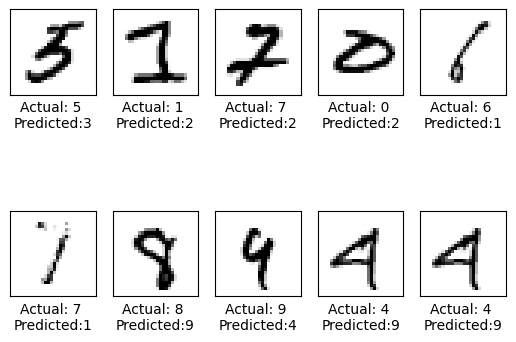

In [62]:
plot_misclassified(misclassified)

## Batch Normalization + L1

In [63]:
model_ = Net(norm='bn').to(device)
summary(model_, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
       BatchNorm2d-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             576
      BatchNorm2d-12            [-1, 8, 10, 10]              16
             ReLU-13            [-1, 8, 10, 10]               0
          Dropout-14            [-1, 8,

In [64]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [65]:
model =  Net(norm='bn').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)



for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, l1_loss=True, lambda_l1=0.00003)
    scheduler.step()
    test(model, device, test_loader, epoch)

EPOCH: 0


Loss=0.1107943207025528 Batch_id=468 Accuracy=92.27: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s] 



Test set: Average loss: 0.1116, Accuracy: 9639/10000 (96.39%)

EPOCH: 1


Loss=0.08742523193359375 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]



Test set: Average loss: 0.0487, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.12873594462871552 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s] 



Test set: Average loss: 0.0433, Accuracy: 9866/10000 (98.66%)

EPOCH: 3


Loss=0.06492868810892105 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s] 



Test set: Average loss: 0.0385, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.09915237128734589 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s] 



Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH: 5


Loss=0.05730060860514641 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s] 



Test set: Average loss: 0.0212, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.09949502348899841 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s] 



Test set: Average loss: 0.0204, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.07830581068992615 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s] 



Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


Loss=0.06379851698875427 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s] 



Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.06808160990476608 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s] 



Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.06343047320842743 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s] 



Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.15761291980743408 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 31.35it/s] 



Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.10403423011302948 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s] 



Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.09348726272583008 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s] 



Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.08670064061880112 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s] 



Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.09353979676961899 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s] 



Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.06300917267799377 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s] 



Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.12165229767560959 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s] 



Test set: Average loss: 0.0192, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.05406082794070244 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s] 



Test set: Average loss: 0.0192, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.061411187052726746 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]



Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)



In [66]:
losses.append(test_losses)
accuracies.append(test_acc)

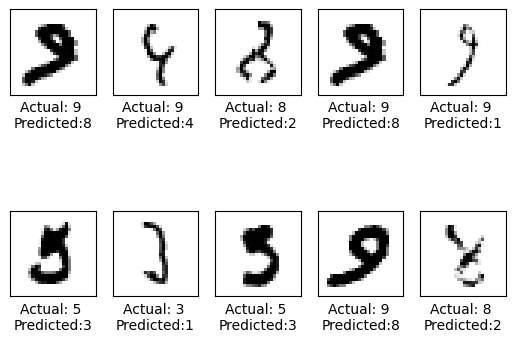

In [67]:
plot_misclassified(misclassified)

### plotting test loss and accuracy

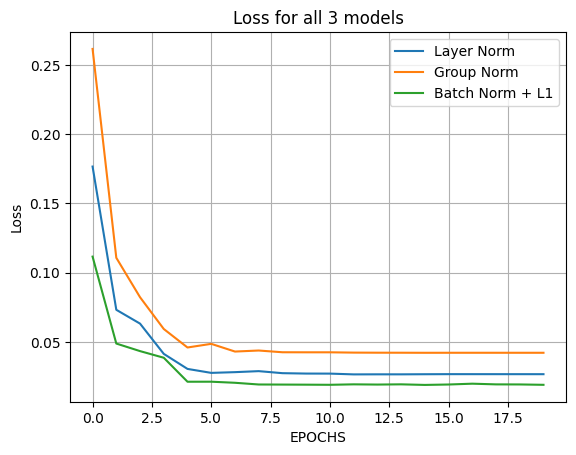

In [68]:
epochs = [i for i in range(EPOCHS)]
plt.plot(epochs,losses[0], label="Layer Norm")
plt.plot(epochs,losses[1], label="Group Norm")
plt.plot(epochs,losses[2], label="Batch Norm + L1")
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title("Loss for all 3 models")
plt.grid()
plt.legend()
plt.show()

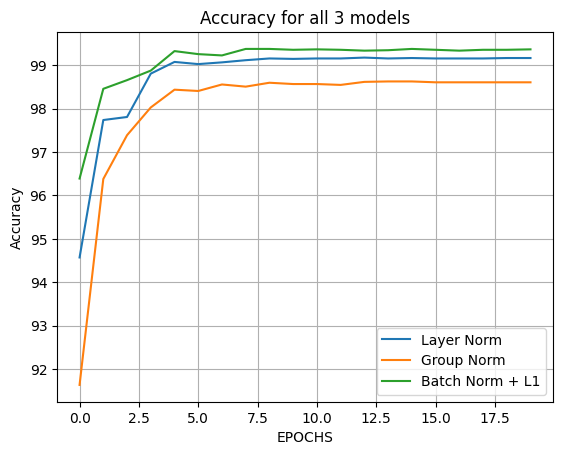

In [69]:
epochs = [i for i in range(EPOCHS)]
plt.plot(epochs,accuracies[0], label="Layer Norm")
plt.plot(epochs,accuracies[1], label="Group Norm")
plt.plot(epochs,accuracies[2], label="Batch Norm + L1")
plt.xlabel('EPOCHS')
plt.ylabel('Accuracy')
plt.title("Accuracy for all 3 models")
plt.grid()
plt.legend()
plt.show()